# Data Scientist - Task 3
### Ricko Rinaldy

### 23 March 2024

## 1. Import Module & Package

In [2]:
import re
import nltk
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from wordcloud import WordCloud

import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score


nltk.download("stopwords")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ICRAVER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ICRAVER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 2. Data Preprocessing

### 2.1 Data Load

In [3]:
with open("data/training.json") as t:
    string_json_list = t.read().split("\n")

json_list = [json.loads(train_json) for train_json in string_json_list[1:] if len(train_json)>10]
train_data = pd.DataFrame(json_list)

In [4]:
df = train_data.copy()
df.head()

,city,category,section,heading
0,newyork,cell-phones,for-sale,New batteries C-S2 for Blackberry 7100/7130/87...
1,newyork,cell-phones,for-sale,******* Brand New Original SAMSUNG GALAXY NO...
2,newyork,cell-phones,for-sale,SAMSUNG GALAXY SIII T-999 MARBLE WHITE T-MOBIL...
3,newyork,cell-phones,for-sale,Ipad mini 64gb 4g any sim unlock
4,newyork,cell-phones,for-sale,htc evo 4g lte for trade


In [5]:
with open("data/sample-test.in.json", encoding="utf8") as t:
    string_json_list = t.read().split("\n")

json_list = [json.loads(train_json) for train_json in string_json_list[1:] if len(train_json)>10]
test_data = pd.DataFrame(json_list)

In [6]:
test_data.head()

,city,section,heading
0,chicago,for-sale,Madden NFL 25 XBOX 360. Brand New!
1,paris.en,housing,looking for room to rent.
2,newyork,for-sale,two DS game
3,seattle,housing,map
4,singapore,services,Good Looking Asian Sensation N aughty Girl ---...


### 2.2 Text Preprocessing

In [7]:
def text_preprocessing(ds: pd.Series) -> pd.Series:
    for m in range(len(ds)):

        main_words = re.sub('[^a-zA-Z]', ' ', ds[m])
        main_words = (main_words.lower()).split()
        main_words = [w for w in main_words if not w in set(stopwords.words('english'))]

        lem = WordNetLemmatizer()
        main_words = [lem.lemmatize(w) for w in main_words if len(w) > 1]

        main_words = ' '.join(main_words)
        ds[m] = main_words

    return ds

In [8]:
df["heading"] = text_preprocessing(df["heading"])
df.head()

,city,category,section,heading
0,newyork,cell-phones,for-sale,new battery blackberry curve pearl
1,newyork,cell-phones,for-sale,brand new original samsung galaxy note battery
2,newyork,cell-phones,for-sale,samsung galaxy siii marble white mobile smartp...
3,newyork,cell-phones,for-sale,ipad mini gb sim unlock
4,newyork,cell-phones,for-sale,htc evo lte trade


In [9]:
test_data["heading"] = text_preprocessing(test_data["heading"])
test_data.head()

,city,section,heading
0,chicago,for-sale,madden nfl xbox brand new
1,paris.en,housing,looking room rent
2,newyork,for-sale,two d game
3,seattle,housing,map
4,singapore,services,good looking asian sensation aughty girl indep...


## 3. Explore Data

### 3.1 Check Empty Data

In [10]:
df[df.isna().any(axis=1)]

,city,category,section,heading


### 3.2 Count of Various "City" in Data

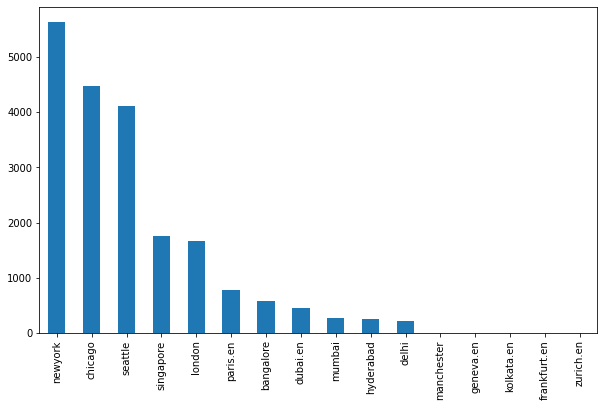

In [11]:
df["city"].value_counts().plot(
    kind="bar",
    figsize=(10,6)
);

### 3.3 Count of Various "Category" in Data

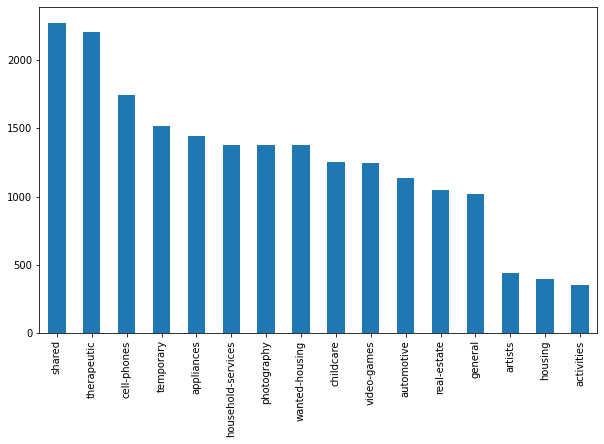

In [12]:
df["category"].value_counts().plot(
    kind="bar",
    figsize=(10,6)
);

### 3.4 Proportion of Various "Section" in Data

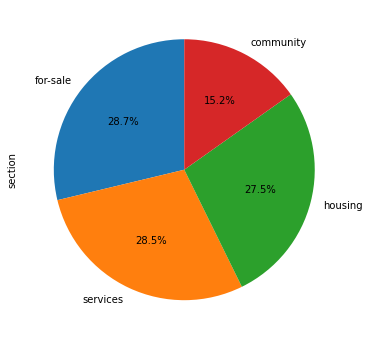

In [13]:
df["section"].value_counts().plot(
    kind="pie",
    figsize=(10, 6),
    autopct="%1.1f%%",
    startangle=90,
);

### 3.5 Word occurence in "Heading" column

           word_count
map              2651
room             1454
amp              1094
service           954
new               913
call              770
looking           715
rent              701
massage           679
available         634


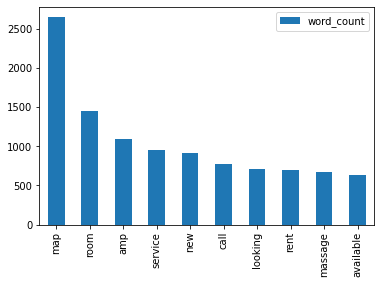

In [14]:
corpus = " ".join(review for review in df["heading"])
corpus_dict = dict(Counter(corpus.split(' ')))
corpus_df = pd.DataFrame(corpus_dict, index=["word_count"]).T
corpus_df = corpus_df.sort_values(by="word_count",ascending=False)
corpus_df = corpus_df.head(len(corpus_df[corpus_df["word_count"]>=16]))
print(corpus_df.head(10))
corpus_df.head(10).plot(kind="bar");

Words Count:  9128


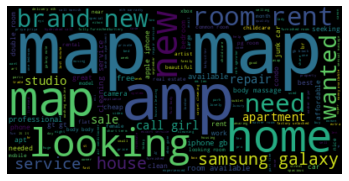

<Figure size 432x288 with 0 Axes>

In [15]:
print("Words Count: ",len(set(corpus.split(" "))))

wordcloud = WordCloud(random_state=27)

wordcloud.generate(corpus)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.figure()
plt.show()

## 4. Model Training

### 4.1 Feature Engineering

In [16]:
def one_hot_encoding(feature: np.array) -> np.array:
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(feature)

    onehot_encoder = OneHotEncoder(sparse=True)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    return onehot_encoded

def preprocessing(df: pd.DataFrame) -> np.array:
    X_section = one_hot_encoding(df["section"].values).toarray()
    X_city = one_hot_encoding(df["city"].values).toarray()

    tfidf = TfidfVectorizer(max_features=len(corpus_df[corpus_df["word_count"]>=16]))
    X_heading = tfidf.fit_transform(df['heading'].values).toarray()

    X = np.concatenate((X_section, X_city, X_heading), axis=1)

    return X

In [17]:
df_no_map = df[df["heading"]!="map"]
X = preprocessing(df_no_map)
Y = df_no_map["category"].values

print("X:\n", X,"\n")
print("Y:\n", Y)

X:
 [[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 

Y:
 ['cell-phones' 'cell-phones' 'cell-phones' ... 'therapeutic' 'therapeutic'
 'therapeutic']


### 4.2 ML + Sampling Data

In [18]:
smote_tomek = SMOTETomek(random_state=27)
X_resampled, Y_resampled = smote_tomek.fit_resample(X, Y)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, test_size=0.2, random_state=27,)

ml_model = RandomForestClassifier(random_state=27)

ml_model.fit(X_train, y_train)

y_pred = ml_model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')

Accuracy: 0.92


In [20]:
report = classification_report(y_test, y_pred)
print(report)

                    precision    recall  f1-score   support

        activities       0.88      0.90      0.89       454
        appliances       0.94      0.93      0.94       460
           artists       0.94      0.89      0.91       427
        automotive       0.92      0.95      0.93       411
       cell-phones       0.99      0.95      0.97       434
         childcare       0.98      0.96      0.97       449
           general       0.84      0.89      0.87       446
household-services       0.92      0.85      0.89       455
           housing       0.96      0.99      0.97       438
       photography       0.97      0.91      0.94       414
       real-estate       0.90      0.92      0.91       462
            shared       0.88      0.82      0.85       404
         temporary       0.87      0.88      0.88       434
       therapeutic       0.97      0.98      0.97       425
       video-games       0.88      0.96      0.91       454
    wanted-housing       0.88      0.90

In [ ]:
sk_folds = StratifiedKFold(n_splits = 5)
scores = cross_val_score(ml_model, X, Y, cv = sk_folds)

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores:  [0.65139442 0.7618099  0.79447765 0.77967549 0.7127811 ]
Average CV Score:  0.7400277139581238
Number of CV Scores used in Average:  5


In [ ]:
with open("ml_model.h5","wb") as m:
    pickle.dump(ml_model, m)

### 4.3 Neural Network

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[-1],)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64, activation='relu'),

    tf.keras.layers.Dense(16, activation='softmax')
])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              run_eagerly=True)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               243712    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 16)                1040      
                                                                 
Total params: 285904 (1.09 MB)
Trainable params: 285904 

In [ ]:
label_encoder = LabelEncoder()
Y_label = label_encoder.fit_transform(Y)

onehot_encoder = OneHotEncoder(sparse=True)
integer_encoded = Y_label.reshape(len(Y_label), 1)
Y_onehot = onehot_encoder.fit_transform(integer_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, Y_onehot, test_size=0.2, random_state=27,)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
lr_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=5,
    min_lr=0.001)

model_checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True)

history = model.fit(
    X_train, y_train.toarray(),
    epochs=100,
    validation_data=(X_test, y_test.toarray()),
    callbacks=[lr_reduction, model_checkpoint],
    verbose=1)

Epoch 1/100
440/440 [==============================] - ETA: 0s - loss: 1.0268 - accuracy: 0.6151
Epoch 00001: val_accuracy improved from -inf to 0.81816, saving model to best_model.h5
440/440 [==============================] - 28s 62ms/step - loss: 1.0268 - accuracy: 0.6151 - val_loss: 0.4633 - val_accuracy: 0.8182 - lr: 0.0010
Epoch 2/100
  2/440 [..............................] - ETA: 28s - loss: 0.4548 - accuracy: 0.8750

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


440/440 [==============================] - ETA: 0s - loss: 0.4613 - accuracy: 0.8194
Epoch 00002: val_accuracy improved from 0.81816 to 0.84832, saving model to best_model.h5
440/440 [==============================] - 31s 70ms/step - loss: 0.4613 - accuracy: 0.8194 - val_loss: 0.3899 - val_accuracy: 0.8483 - lr: 0.0010
Epoch 3/100
439/440 [============================>.] - ETA: 0s - loss: 0.3739 - accuracy: 0.8593
Epoch 00003: val_accuracy improved from 0.84832 to 0.85828, saving model to best_model.h5
440/440 [==============================] - 27s 62ms/step - loss: 0.3740 - accuracy: 0.8592 - val_loss: 0.3728 - val_accuracy: 0.8583 - lr: 0.0010
Epoch 4/100
439/440 [============================>.] - ETA: 0s - loss: 0.3331 - accuracy: 0.8715
Epoch 00004: val_accuracy improved from 0.85828 to 0.86113, saving model to best_model.h5
440/440 [==============================] - 26s 60ms/step - loss: 0.3332 - accuracy: 0.8714 - val_loss: 0.3763 - val_accuracy: 0.8611 - lr: 0.0010
Epoch 5/100
4

In [ ]:
nn_model = tf.keras.models.load_model("nn_model.h5")
y_pred = nn_model.predict(X_test)

y_pred_label = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))
y_test_label = label_encoder.inverse_transform(np.argmax(y_test.toarray(), axis=1))

print(f'Accuracy: {accuracy_score(y_test_label, y_pred_label):.2f}')

110/110 [==============================] - 0s 2ms/step
Accuracy: 0.87


In [ ]:
report = classification_report(y_test_label, y_pred_label)
print(report)

                    precision    recall  f1-score   support

        activities       0.61      0.52      0.56        60
        appliances       0.92      0.92      0.92       250
           artists       0.72      0.72      0.72        76
        automotive       0.92      0.90      0.91       195
       cell-phones       0.98      0.97      0.98       356
         childcare       0.95      0.91      0.93       196
           general       0.74      0.81      0.77       158
household-services       0.79      0.90      0.84       265
           housing       0.71      0.82      0.76        50
       photography       0.95      0.90      0.92       238
       real-estate       0.86      0.70      0.77       189
            shared       0.81      0.79      0.80       320
         temporary       0.70      0.71      0.71       203
       therapeutic       0.98      0.98      0.98       419
       video-games       0.87      0.92      0.89       228
    wanted-housing       0.85      0.83

In [ ]:
X_new_sample = preprocessing(test_data)
new_heading = nn_model.predict(X_new_sample)
test_data["category"] = label_encoder.inverse_transform(np.argmax(new_heading, axis=1))
test_data.category.value_counts()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


481/481 [==============================] - 2s 3ms/step


wanted-housing        2546
appliances            1518
general               1474
photography           1451
household-services    1443
therapeutic           1281
shared                1240
automotive            1028
video-games            768
cell-phones            662
real-estate            562
artists                474
temporary              434
activities             200
childcare              198
housing                 91
Name: category, dtype: int64

In [ ]:
with open("ml_model.h5","rb") as m:
    ml_model = pickle.load(m)

X_new_sample = preprocessing(test_data)
new_heading = ml_model.predict(X_new_sample)
test_data["category"] = new_heading
test_data.category.value_counts()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


video-games           2235
wanted-housing        1616
therapeutic           1492
shared                1230
automotive            1180
general               1125
appliances            1033
real-estate            876
housing                866
household-services     760
photography            716
activities             682
temporary              618
cell-phones            409
artists                316
childcare              216
Name: category, dtype: int64

In [ ]:
test_data

,city,section,heading,category
0,chicago,for-sale,madden nfl xbox brand new,photography
1,paris.en,housing,looking room rent,temporary
2,newyork,for-sale,two d game,appliances
3,seattle,housing,map,wanted-housing
4,singapore,services,good looking asian sensation aughty girl indep...,therapeutic
...,...,...,...,...
15365,newyork,services,nissan ud isuzu npr fuso hino truck amp auto part,automotive
15366,seattle,for-sale,map,video-games
15367,seattle,services,old school upholstery amp repair,automotive
15368,newyork,for-sale,lg super capacity cuft french door refrigerato...,photography


In [ ]:
nn_model = tf.keras.models.load_model("nn_model.h5")

X_new_sample = preprocessing(test_data)
new_heading = nn_model.predict(X_new_sample)
test_data["category"] = label_encoder.inverse_transform(np.argmax(new_heading, axis=1))
test_data.category.value_counts()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


481/481 [==============================] - 1s 2ms/step


wanted-housing        2546
appliances            1518
general               1474
photography           1451
household-services    1443
therapeutic           1281
shared                1240
automotive            1028
video-games            768
cell-phones            662
real-estate            562
artists                474
temporary              434
activities             200
childcare              198
housing                 91
Name: category, dtype: int64

In [ ]:
test_data

,city,section,heading,category
0,chicago,for-sale,madden nfl xbox brand new,video-games
1,paris.en,housing,looking room rent,temporary
2,newyork,for-sale,two d game,appliances
3,seattle,housing,map,wanted-housing
4,singapore,services,good looking asian sensation aughty girl indep...,household-services
...,...,...,...,...
15365,newyork,services,nissan ud isuzu npr fuso hino truck amp auto part,automotive
15366,seattle,for-sale,map,photography
15367,seattle,services,old school upholstery amp repair,household-services
15368,newyork,for-sale,lg super capacity cuft french door refrigerato...,photography


In [ ]:
with open("label_encoder_category.pkl", "wb") as e:
  pickle.dump(label_encoder, e)